In [1]:
import sys
import pathlib
from itertools import product, tee
from dataclasses import dataclass
from typing import Tuple, List
import math

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import momepy
from shapely import geometry, ops
from shapely.geometry import LineString
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("..")

In [5]:
from src.preprocess import transform_df_to_trajectory_gdf

In [6]:
mpl.rcParams["figure.facecolor"] = "w"

## Read traffic lanes

Read traffic lanes as geopandas dataframe

In [7]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [8]:
trafficlanes.head()

,identifier,type,successors,geometry
0,308840,NORMAL,None,"LINESTRING (619275.680 5809210.783, 619270.841..."
1,308827,NORMAL,"1382090,1382091","LINESTRING (619267.575 5809220.289, 619272.474..."
2,307911,NORMAL,"1381550,1381551","LINESTRING (619301.721 5809211.188, 619289.351..."
3,307900,NORMAL,None,"LINESTRING (619290.881 5809202.915, 619303.266..."
4,1381551,NORMAL,307861,"LINESTRING (619289.351 5809205.791, 619286.761..."


Read traffic lanes as a `networkx.classes.digraph.DiGraph`

In [9]:
traffic_lanes_graph = momepy.gdf_to_nx(trafficlanes, approach='primal', directed=True, multigraph=False)

In [10]:
traffic_lanes_graph

## Generate possible paths

In [11]:
len(traffic_lanes_graph.nodes), len(traffic_lanes_graph.edges)

(44, 48)

Find nodes with only one incoming and outgoing edge

In [12]:
start_nodes = [node for node, degree in traffic_lanes_graph.in_degree if degree == 0]
end_nodes = [node for node, degree in traffic_lanes_graph.out_degree if degree == 0]

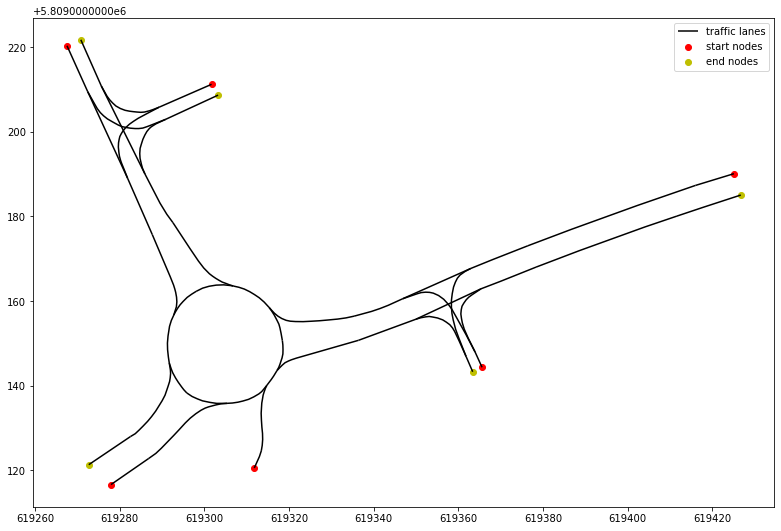

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

start_nodes_matrix = np.array(start_nodes)
ax.scatter(start_nodes_matrix[:, 0], start_nodes_matrix[:, 1], color="r", label="start nodes")

end_nodes_matrix = np.array(end_nodes)
ax.scatter(end_nodes_matrix[:, 0], end_nodes_matrix[:, 1], color="y", label="end nodes")

ax.legend()

Find all possible paths between the combination of start- and end nodes

In [14]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [15]:
def graph_path_to_linestring(G, path: List[object]) -> LineString:
    lines = list()
    for n0, n1 in pairwise(path):
        geometry = G.edges[n0, n1]['geometry']
        lines.append(geometry)
    ls = ops.linemerge(lines)
    return ls

In [16]:
@dataclass
class DrivablePath:
    """Data structure representing a drivable path (extracted from the map graph)
    """
    id: int
    path: LineString
    
    def plot(self, ax, color=None):
        ls = self.path
        x, y = ls.xy
        ax.plot(x, y, label=str(self.id), color=color)
        ax.scatter([x[0], x[-1]], [y[0], y[-1]], color=color)
    
    @property
    def length(self) -> float:
        ls = self.path
        return ls.length

In [17]:
paths = list()
for i, (start, end) in enumerate(product(start_nodes, end_nodes)):
    path = nx.shortest_path(traffic_lanes_graph, start, end)
    path_as_ls = graph_path_to_linestring(traffic_lanes_graph, path)
    paths.append(DrivablePath(i, path_as_ls))

In [18]:
num_paths = len(paths)

In [19]:
print(num_paths, "paths found!")

30 paths found!


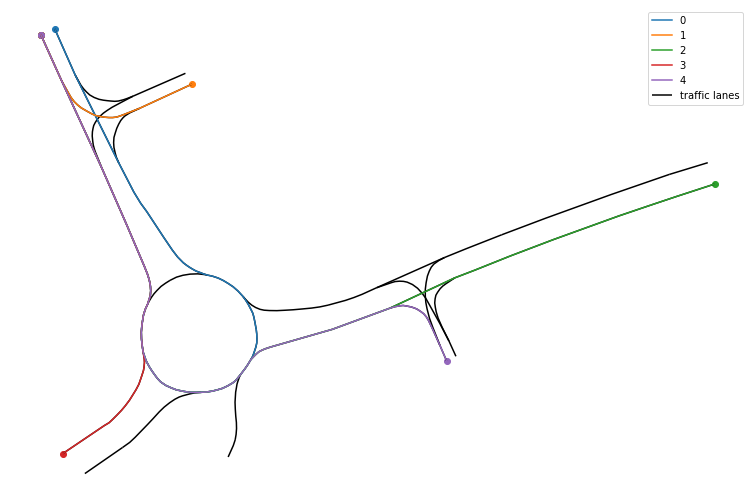

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

for dp in paths[:5]:
    dp.plot(ax)

ax.legend()
ax.set_axis_off()

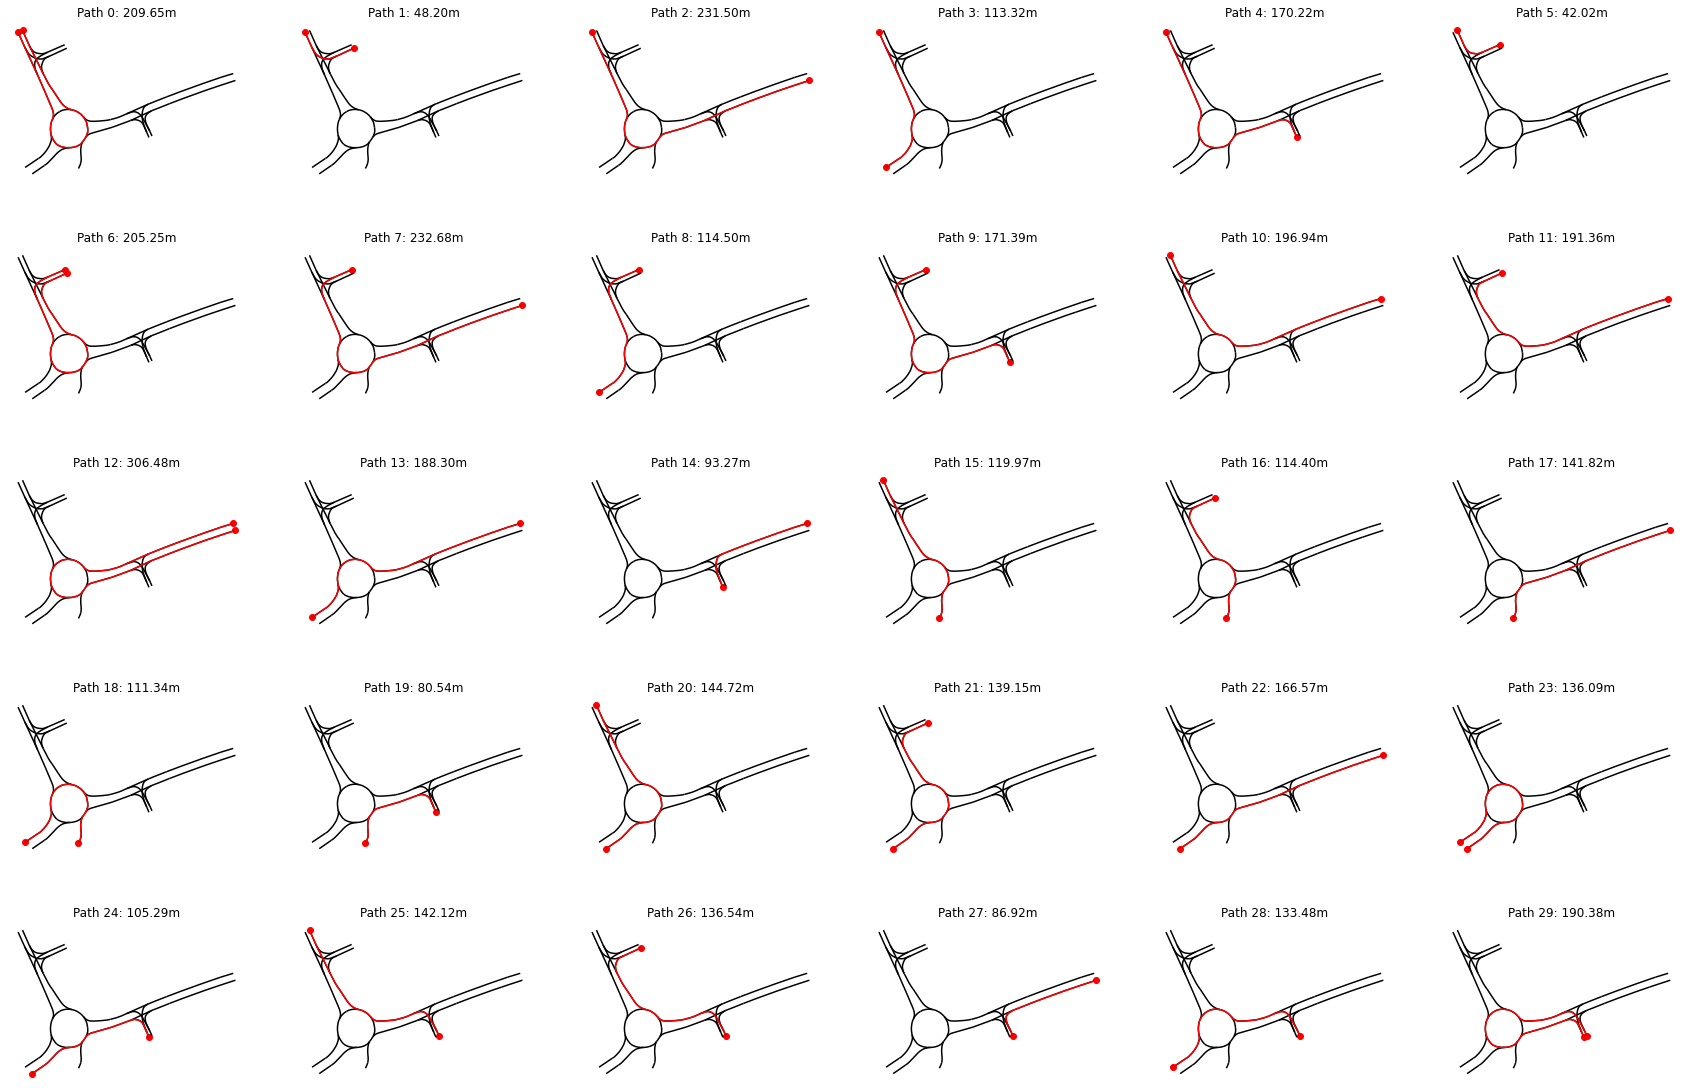

In [21]:
fig, axs = plt.subplots(nrows=math.ceil(num_paths/6), ncols=6, figsize=(30, 20))
axs = axs.flatten()

for i, dp in enumerate(paths):
    axi = axs[i]
    trafficlanes.plot(ax=axi, color="k", label="traffic lanes")
    dp.plot(axi, color="red")
    axi.set_axis_off()
    axi.set_title(f"Path {i}: {dp.length:.2f}m")

## Assign trajectory data to paths

In [289]:
from src.opendd import VEHICLE_CLASSES
from src.preprocess import transform_df_to_trajectory_gdf

In [290]:
data_path = "../data/raw/rdb1.parquet"

In [291]:
VEHICLE_SAMPLE_RATE = 30.0

In [292]:
df = pd.read_parquet(data_path)

In [293]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1


In [294]:
df = df[df["table"] == "rdb1_1"]

In [295]:
gdf_traces = transform_df_to_trajectory_gdf(df)

In [296]:
# keep only motorized vehicles
gdf_traces = gdf_traces[gdf_traces["CLASS"].isin(VEHICLE_CLASSES)]

In [297]:
gdf_traces.head()

,OBJID,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,acceleration,acc_tan,geometry
OBJID,,,,,,,,,
1,1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[0.14143585118349591, 0.1340662895734793, 0.13...","[0.0747, 0.0679, 0.0776, 0.1013, 0.1388, 0.251...","LINESTRING (619302.330 5809133.780, 619302.470..."
2,2,Car,1.7950,4.3806,0.0,556,"[0.10922019044114507, 0.1466594695203825, 0.19...","[0.0672, 0.1046, 0.1552, 0.2462, 0.377, 0.485,...","LINESTRING (619286.670 5809178.010, 619286.680..."
3,3,Car,1.8667,3.7854,0.0,241,"[0.06932971945709862, 0.055617353407007776, 0....","[0.0681, 0.0535, 0.0335, -0.0144, -0.0927, -0....","LINESTRING (619281.510 5809126.720, 619281.470..."
4,4,Car,1.7642,4.4819,0.0,286,"[0.919936432586513, 1.0231443690897195, 1.1120...","[-0.8548, -0.9502, -1.0321, -1.0997, -1.1539, ...","LINESTRING (619288.840 5809134.990, 619288.780..."
5,5,Medium Vehicle,2.1041,4.8186,0.0,216,"[1.3950192113372488, 1.5709136990936199, 1.731...","[0.6932, 0.7812, 0.8543, 0.9117, 0.9548, 1.005...","LINESTRING (619316.990 5809146.380, 619317.010..."


In [298]:
gdf_traces.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 332 entries, 1 to 356
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJID         332 non-null    int64   
 1   CLASS         332 non-null    object  
 2   WIDTH         332 non-null    float64 
 3   LENGTH        332 non-null    float64 
 4   START_TIME    332 non-null    float64 
 5   NUM_SAMPLES   332 non-null    int64   
 6   acceleration  332 non-null    object  
 7   acc_tan       332 non-null    object  
 8   geometry      332 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(3)
memory usage: 25.9+ KB


### Single vehicle example

In [299]:
vehicle_path = gdf_traces.iloc[1]

In [300]:
vehicle_path

OBJID                                                           2
CLASS                                                         Car
WIDTH                                                       1.795
LENGTH                                                     4.3806
START_TIME                                                    0.0
NUM_SAMPLES                                                   556
acceleration    [0.10922019044114507, 0.1466594695203825, 0.19...
acc_tan         [0.0672, 0.1046, 0.1552, 0.2462, 0.377, 0.485,...
geometry        LINESTRING (619286.67 5809178.01, 619286.68000...
Name: 2, dtype: object

In [301]:
vehicle_path_linestring = vehicle_path.geometry

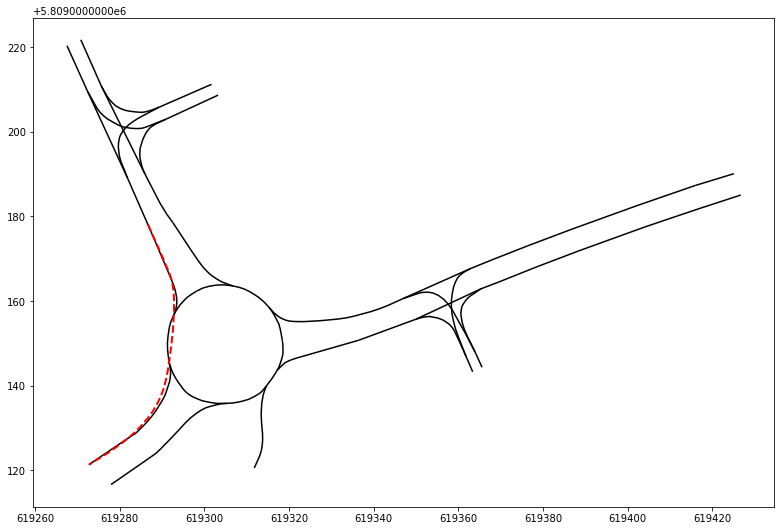

In [302]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
ax.plot(*vehicle_path_linestring.xy, lw=2, c="red", ls="--")

In [303]:
from scipy.spatial.distance import directed_hausdorff
from shapely.geometry import LineString

In [304]:
def compute_path_distance(ls1: LineString, ls2: LineString, N: int = 100) -> float:
    
    # linestrings have to be distretized to call `scipy.spatial.distance.directed_hausdorff`
    ls1_pts = LineString([ls1.interpolate(s, normalized=True) for s in np.linspace(0, 1, N)])
    ls1_pts = np.array(ls1_pts.xy).T  # N x 2
    
    ls2_pts = LineString([ls2.interpolate(s, normalized=True) for s in np.linspace(0, 1, N)])
    ls2_pts = np.array(ls2.xy).T
    
    d = directed_hausdorff(ls1_pts, ls2_pts)[0]
    return d

In [305]:
distances = list()

N = 100

for i, dp in enumerate(paths):
    
    d = compute_path_distance(vehicle_path_linestring, dp.path)
    distances.append(d)

distances = np.array(distances)

In [306]:
print(distances.argmin())

3


In [307]:
d

28.4906168176829

Text(0, 0.5, 'directed_hausdorff [m]')

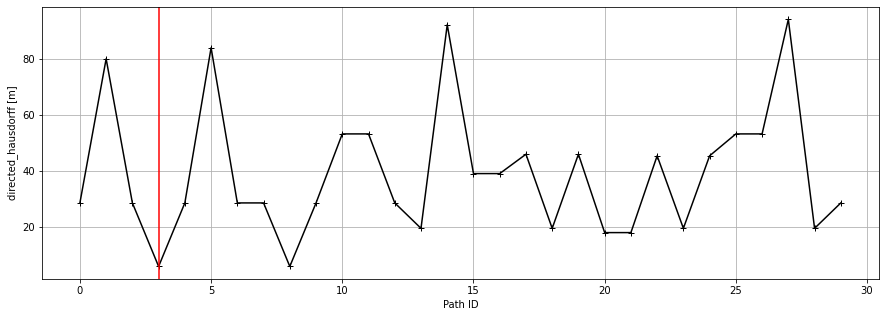

In [308]:
plt.figure(figsize=(15, 5))
plt.plot(distances, "k+-")
plt.axvline(distances.argmin(), color="r")
plt.grid()
plt.xlabel("Path ID")
plt.ylabel("directed_hausdorff [m]")

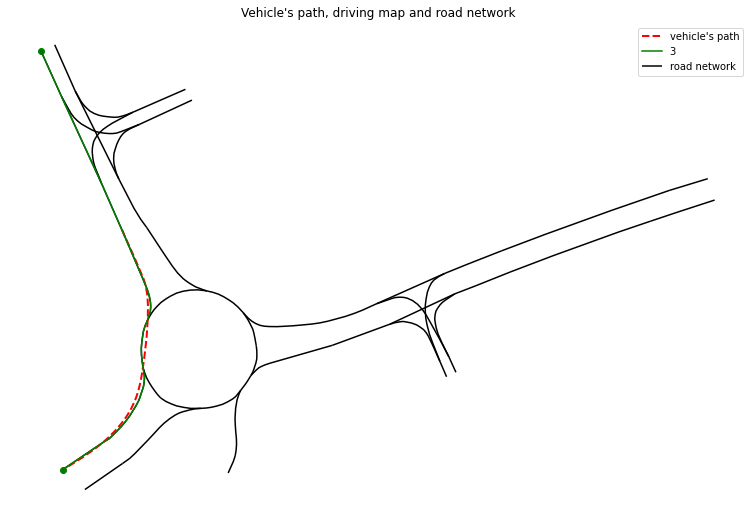

In [309]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="road network")
ax.plot(*vehicle_path_linestring.xy, lw=2, c="red", ls="--", label="vehicle's path")
paths[distances.argmin()].plot(ax, color="green")
ax.set_axis_off()
ax.set_title("Vehicle's path, driving map and road network")
ax.legend()

## Multiple paths

In [310]:
paths_as_linestrings = [dp.path for dp in paths]

In [311]:
def find_nearest_path(ls: LineString, paths: List[LineString], N: int = 100) -> int:
    """Returns the index of the path list `paths` with minimal distance to `ls` wrt. to
    `directed_hausdorff` metric.
    """
    
    distances = np.zeros(len(paths), dtype=float)
    
    for i, path in enumerate(paths):
    
        d = compute_path_distance(ls, path, N)
        distances[i] = d

    return distances.argmin()

In [312]:
tqdm.pandas()

In [313]:
gdf_traces["path_id"] = gdf_traces.progress_apply(lambda row: find_nearest_path(row["geometry"], paths_as_linestrings, N=20), axis=1)

  0%|          | 0/332 [00:00<?, ?it/s]

In [314]:
gdf_traces.head()

,OBJID,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,acceleration,acc_tan,geometry,path_id
OBJID,,,,,,,,,,
1,1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[0.14143585118349591, 0.1340662895734793, 0.13...","[0.0747, 0.0679, 0.0776, 0.1013, 0.1388, 0.251...","LINESTRING (619302.330 5809133.780, 619302.470...",0
2,2,Car,1.7950,4.3806,0.0,556,"[0.10922019044114507, 0.1466594695203825, 0.19...","[0.0672, 0.1046, 0.1552, 0.2462, 0.377, 0.485,...","LINESTRING (619286.670 5809178.010, 619286.680...",3
3,3,Car,1.8667,3.7854,0.0,241,"[0.06932971945709862, 0.055617353407007776, 0....","[0.0681, 0.0535, 0.0335, -0.0144, -0.0927, -0....","LINESTRING (619281.510 5809126.720, 619281.470...",3
4,4,Car,1.7642,4.4819,0.0,286,"[0.919936432586513, 1.0231443690897195, 1.1120...","[-0.8548, -0.9502, -1.0321, -1.0997, -1.1539, ...","LINESTRING (619288.840 5809134.990, 619288.780...",3
5,5,Medium Vehicle,2.1041,4.8186,0.0,216,"[1.3950192113372488, 1.5709136990936199, 1.731...","[0.6932, 0.7812, 0.8543, 0.9117, 0.9548, 1.005...","LINESTRING (619316.990 5809146.380, 619317.010...",0


In [374]:
gdf_traces["START_TIME"].iloc[:20]

OBJID
2      0.000000
11     0.000000
4      0.000000
1      0.000000
3      0.000000
8      0.000000
9      0.000000
5      0.000000
7      0.000000
6      0.000000
13     2.836167
14     4.504500
15     5.672333
16     6.840167
17     8.008000
18    10.176833
19    11.678333
20    14.347667
21    15.181833
24    17.350667
Name: START_TIME, dtype: float64

In [376]:
10.176833/(1/30)

305.30499000000003

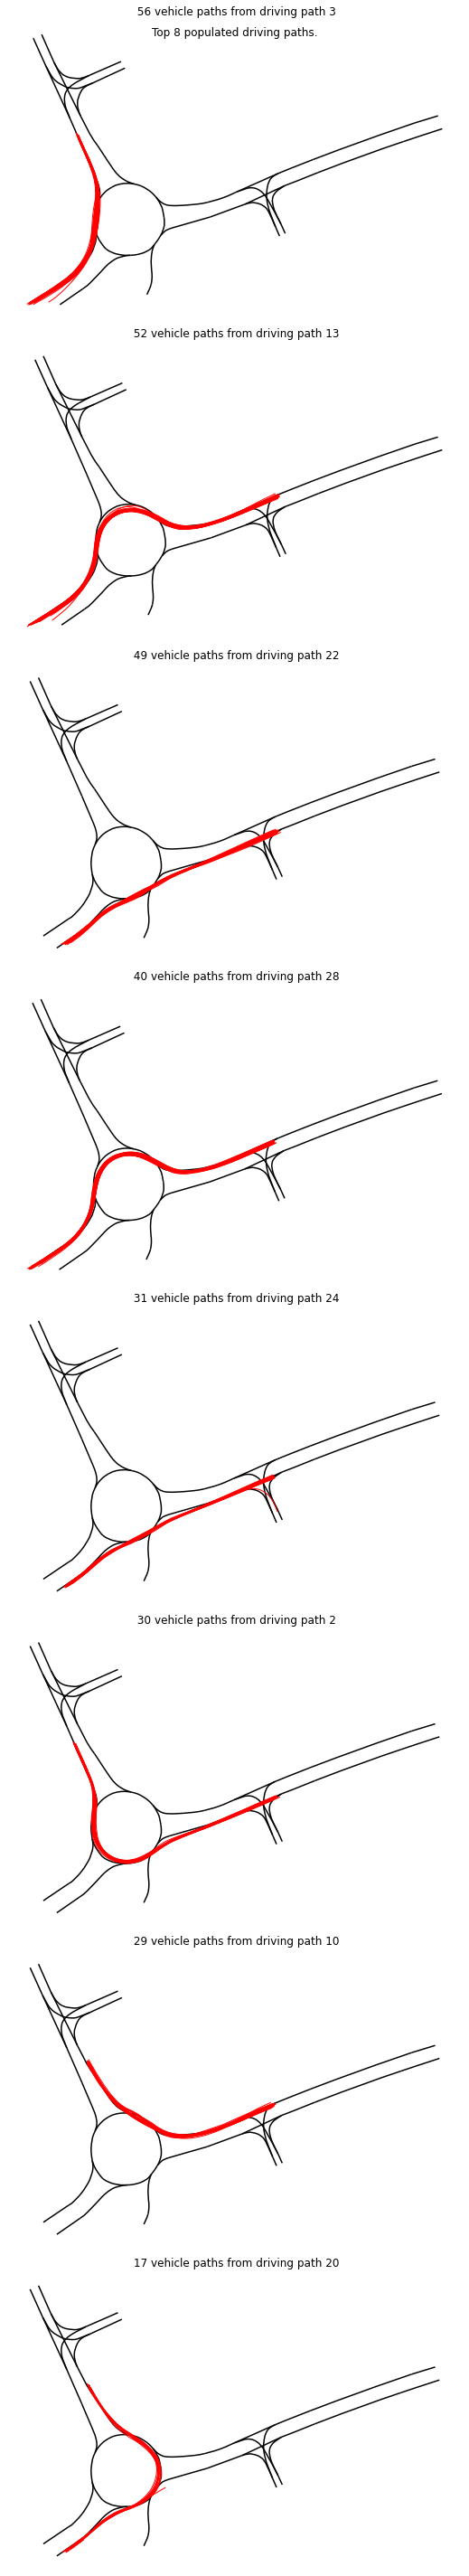

In [315]:
N = 8

fig, axs = plt.subplots(nrows=N, figsize=(10, 5*N))

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    
    for i, vp in vehicle_paths.iterrows():
        ax.plot(*vp.geometry.xy, lw=1, color="r")
    ax.set_axis_off()
    ax.set_title(f"{cnt: d} vehicle paths from driving path {path_id:d}")
    
fig.suptitle(f"Top {N} populated driving paths.")
plt.tight_layout()

## Project to Frenet Frame

Helpful link: https://fjp.at/posts/optimal-frenet/

### Example on single trip

In [316]:
@dataclass
class DiscreteReferencePath:
    
    points: np.ndarray # in cartesian (metric) coordinates, as Nx3
    spatial_resolution: float # approximate
    
    def to_frenet(self, pt: Tuple[float, float]) -> Tuple[float, float]:
        pt = np.array(pt)
        deltas = np.linalg.norm(self.points[:, 1:] - pt, axis=1)
        
        idx_min = np.argmin(deltas)
        
        s = self.points[idx_min, 0]
        d = deltas[idx_min]
        return s,  d
    
    def to_cartesian(self, s: float, d: 0):
        # needs to implement normal unit vector
        pass
    
    @property
    def length(self) -> float:
        return self.points[-1, 0] + self.spatial_resolution
    
    @classmethod
    def from_linestring(cls, ls: LineString, resolution=1.0, cut_length: float = 1.0):
        
        path_samples = np.arange(cut_length, ls.length-cut_length, resolution)
        ls_pts = LineString([ls.interpolate(s, normalized=False) for s in path_samples])
        ls_pts = np.array(ls_pts.xy).T  # N x 2
        
        return cls(np.c_[path_samples, ls_pts], resolution)
    
    def to_frenet_vectorized(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        F = np.zeros((len(x), 2))
        
        for i, (x_pt, y_pt) in enumerate(zip(x, y)):
             F[i, :] = self.to_frenet((x_pt, y_pt))
        
        return F[:, 0], F[:, 1]
    
    def linestring_to_frenet(self, ls: LineString) -> LineString:
        s_arr, d_arr = self.to_frenet_vectorized(*ls.xy)
        return LineString([(s, d) for s, d in zip(s_arr, d_arr)])
    
    def as_linestring(self) -> LineString:
        return LineString([(x, y) for x, y in zip(self.points[:, 1], self.points[:, 2])])
    
    def __str__(self):
        return f"<DiscreteReferencePath with {self.points.shape[0]} samples>"

In [317]:
example_path = paths_as_linestrings[13]
example_reference = DiscreteReferencePath.from_linestring(example_path, 0.1)

In [318]:
example_reference.length

187.40000000000015

In [319]:
example_trip = gdf_traces[gdf_traces["path_id"] == 13].iloc[10]
example_trip

OBJID                                                         162
CLASS                                                         Car
WIDTH                                                      1.9112
LENGTH                                                     4.2946
START_TIME                                             272.438833
NUM_SAMPLES                                                   591
acceleration    [0.13298699184506732, 0.09864202958171532, 0.0...
acc_tan         [-0.1323, -0.0976, -0.0419, 0.0318, 0.1205, 0....
geometry        LINESTRING (619362.96 5809167.38, 619362.91 58...
path_id                                                        13
Name: 162, dtype: object

In [320]:
example_trip_frenet = example_reference.linestring_to_frenet(example_trip.geometry)

(-10.0, 10.0)

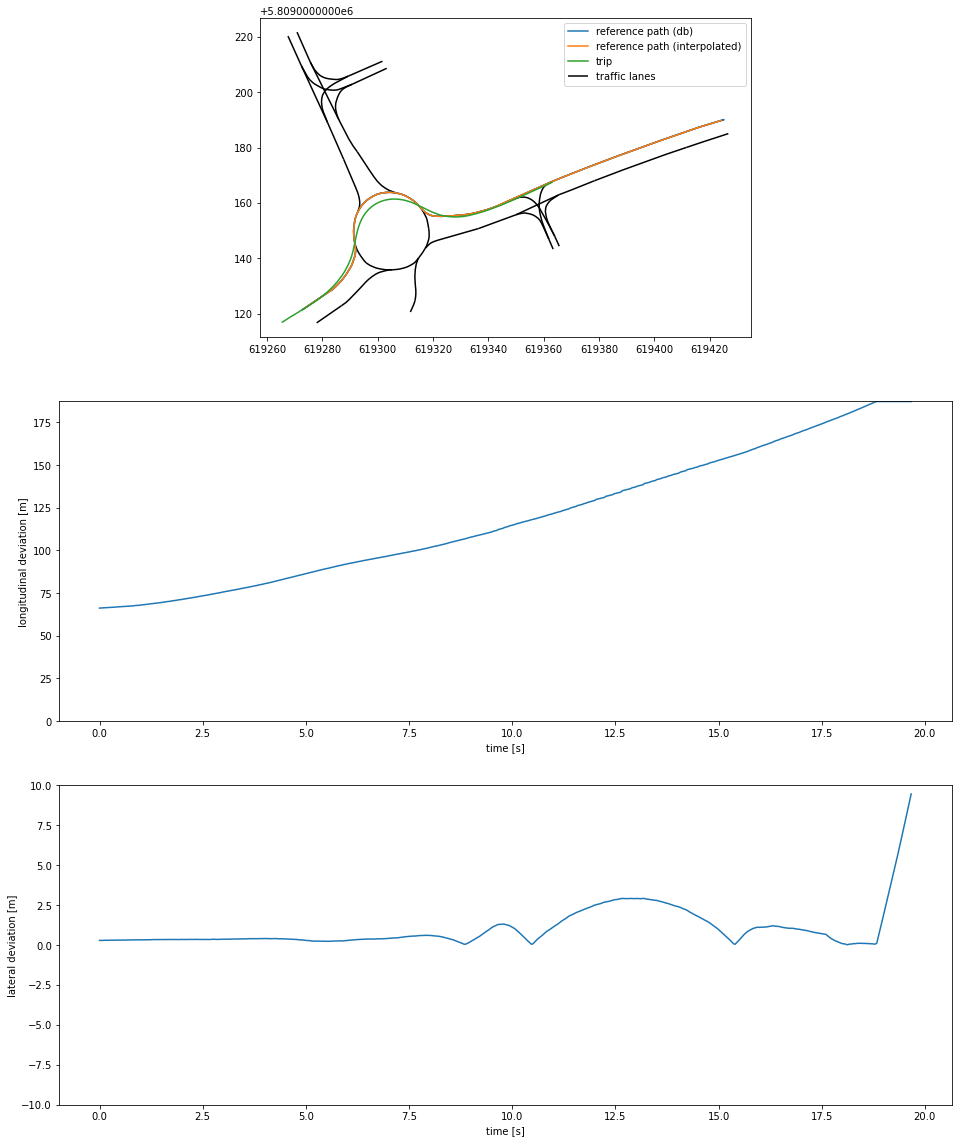

In [321]:
fig, (ax_cart, ax_frenet_lon, ax_frenet_lat) = plt.subplots(nrows=3, figsize=(16, 20))

trafficlanes.plot(ax=ax_cart, color="k", label="traffic lanes")
ax_cart.plot(*example_path.xy, label="reference path (db)")
ax_cart.plot(*example_reference.as_linestring().xy, label="reference path (interpolated)")
ax_cart.plot(*example_trip.geometry.xy, label="trip")
ax_cart.legend()

t_array = 1/30*np.arange(0, len(example_trip_frenet.xy[0]))
s_array, d_array = example_trip_frenet.xy
ax_frenet_lon.plot(t_array, s_array)
ax_frenet_lat.plot(t_array, d_array)

ax_frenet_lon.set_ylabel("longitudinal deviation [m]")
ax_frenet_lat.set_ylabel("lateral deviation [m]")

ax_frenet_lon.set_xlabel("time [s]")
ax_frenet_lat.set_xlabel("time [s]")


ax_frenet_lon.set_ylim([0, example_reference.length])
ax_frenet_lat.set_ylim([-10, 10])

### Project to frenet for all trips

In [322]:
reference_paths = [DiscreteReferencePath.from_linestring(dp.path, resolution=0.05) for dp in paths]

In [323]:
def row_to_frenet(row: pd.Series, reference_paths: List[DiscreteReferencePath]) -> LineString:
    path_id = row["path_id"]
    ref_path = reference_paths[path_id]
    return ref_path.linestring_to_frenet(row["geometry"])

In [328]:
gdf_traces["frenet_path"] = gpd.GeoSeries(gdf_traces.apply(lambda row: row_to_frenet(row, reference_paths), axis=1))

C:\Users\kopyt\AppData\Local\Temp/ipykernel_7936/4207950133.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


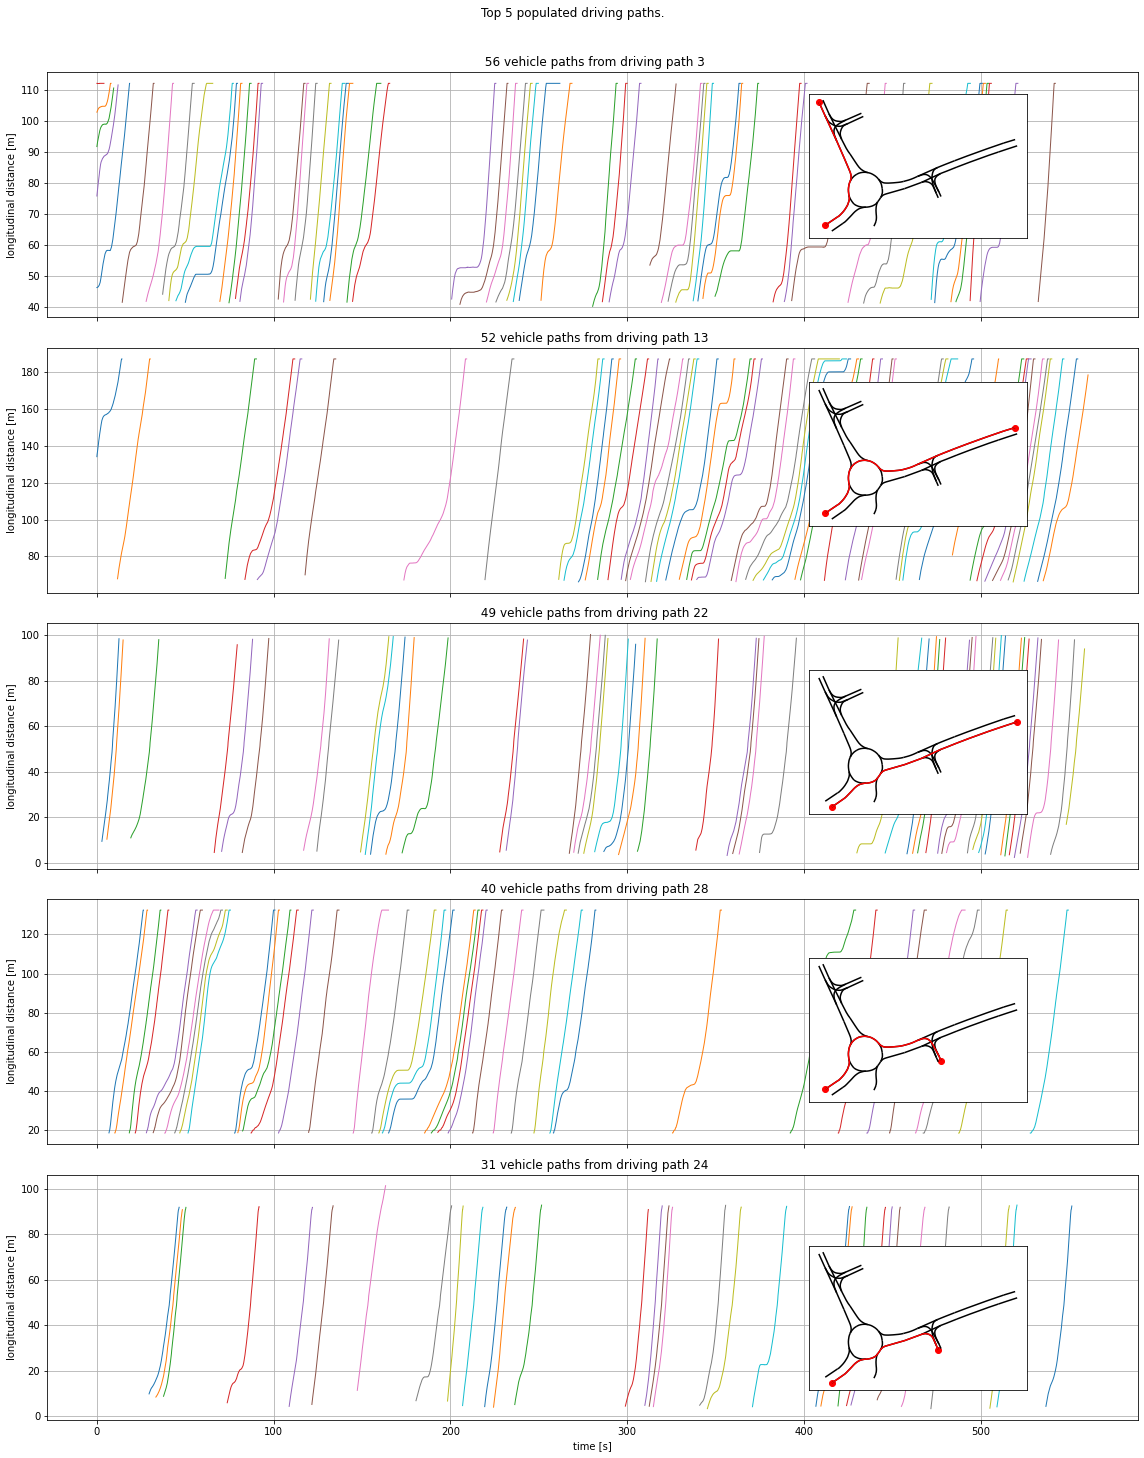

In [329]:
N = 5

fig, axs = plt.subplots(nrows=N, figsize=(16, 4*N), sharex=True)

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    
    map_ax = fig.add_axes([0.7, 0.85 - 1/N*i, 0.2, 1/N*0.5])
    
    trafficlanes.plot(ax=map_ax, color="k", label="road network")
    paths[path_id].plot(map_ax, color="red")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    # map_ax.set_axis_off()
    map_ax.axes.get_xaxis().set_visible(False)
    map_ax.axes.get_yaxis().set_visible(False)
    
    
    for i, vp in vehicle_paths.iterrows():
        
        lon_array, lat_array = vp["frenet_path"].xy
        time_array = vp["START_TIME"] + 1/VEHICLE_SAMPLE_RATE*np.arange(0, vp["NUM_SAMPLES"])
        ax.plot(time_array, lon_array, lw=1)
    ax.set_title(f"{cnt: d} vehicle paths from driving path {path_id:d}")
    
    ax.grid()
    ax.set_ylabel("longitudinal distance [m]")
    
axs[-1].set_xlabel("time [s]")
    
fig.suptitle(f"Top {N} populated driving paths.", y=1.01)
plt.tight_layout()

Assume that all vehicles follow each other (\wo overtakes) - compute the $\Delta s(t)$ between two vehicles (current and consecutive vehicle)

In [331]:
gdf_traces["START_LON"] = gdf_traces["frenet_path"].apply(lambda ls: ls.xy[0][0])

In [384]:
gdf_traces = gdf_traces.sort_values(["path_id","START_TIME", "START_LON"])

In [385]:
gdf_traces.head()

,OBJID,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,acceleration,acc_tan,geometry,path_id,frenet_path,START_LON
OBJID,,,,,,,,,,,,
1,1,Heavy Vehicle,2.7892,6.0217,0.000000,341,"[0.14143585118349591, 0.1340662895734793, 0.13...","[0.0747, 0.0679, 0.0776, 0.1013, 0.1388, 0.251...","LINESTRING (619302.330 5809133.780, 619302.470...",0,"LINESTRING (96.30000 2.09837, 96.40000 2.00893...",96.30
5,5,Medium Vehicle,2.1041,4.8186,0.000000,216,"[1.3950192113372488, 1.5709136990936199, 1.731...","[0.6932, 0.7812, 0.8543, 0.9117, 0.9548, 1.005...","LINESTRING (619316.990 5809146.380, 619317.010...",0,"LINESTRING (116.60000 1.25671, 116.75000 1.285...",116.60
348,348,Car,1.7942,5.1017,548.714833,361,"[1.9395041247700402, 1.861900002685429, 1.8536...","[-1.9395, -1.8619, -1.8536, -1.9038, -2.0037, ...","LINESTRING (619285.220 5809181.730, 619285.290...",0,"LINESTRING (42.40000 0.13615, 42.60000 0.13764...",42.40
353,353,Car,1.7891,4.6541,557.223333,106,"[0.03788680509095482, 0.02984124662275355, 0.0...","[0.0354, 0.0263, 0.0112, -0.0085, -0.0325, -0....","LINESTRING (619284.900 5809182.440, 619284.940...",0,"LINESTRING (41.65000 0.13050, 41.75000 0.12085...",41.65
355,355,Car,1.8142,4.5180,560.059500,21,"[0.19409082925269808, 0.20880615412386674, 0.2...","[-0.087, -0.106, -0.1132, -0.1102, -0.0989, -0...","LINESTRING (619284.620 5809182.700, 619284.650...",0,"LINESTRING (41.25000 0.03433, 41.35000 0.03024...",41.25


In [386]:
from itertools import tee

In [387]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [388]:
gdf_traces_path = gdf_traces.query("path_id == 28")

In [389]:
len(gdf_traces_path)

40

In [390]:
gdf_traces_path.head()

,OBJID,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,acceleration,acc_tan,geometry,path_id,frenet_path,START_LON
OBJID,,,,,,,,,,,,
16,16,Car,2.1239,4.9003,6.840167,586,"[0.32422769776809635, 0.3664038482330665, 0.40...","[-0.2238, -0.2657, -0.303, -0.3365, -0.3674, -...","LINESTRING (619359.920 5809165.130, 619359.630...",28,"LINESTRING (18.60000 5.79179, 18.75000 5.51584...",18.60
18,18,Car,1.8572,4.6855,10.176833,556,"[0.28791701929549074, 0.29389964273540725, 0.3...","[-0.2439, -0.2464, -0.2519, -0.2588, -0.2683, ...","LINESTRING (619360.790 5809165.570, 619360.550...",28,"LINESTRING (18.55000 6.67255, 18.55000 6.44359...",18.55
25,25,Medium Vehicle,1.9958,5.0320,18.351667,536,"[0.34584211715752605, 0.3503526223678082, 0.35...","[-0.3439, -0.3486, -0.3492, -0.3435, -0.3345, ...","LINESTRING (619361.200 5809166.930, 619360.870...",28,"LINESTRING (18.60000 8.00032, 18.80000 7.68466...",18.60
28,28,Car,1.9468,4.6194,21.688333,571,"[0.3829262592197093, 0.42920223671364993, 0.45...","[-0.3604, -0.4084, -0.4369, -0.451, -0.4516, -...","LINESTRING (619360.750 5809165.730, 619360.440...",28,"LINESTRING (18.55000 6.77157, 18.55000 6.47885...",18.55
34,34,Car,1.8456,4.4256,28.028000,861,"[0.13646160632207138, 0.10021027891389186, 0.0...","[0.1364, 0.1001, 0.0432, -0.0332, -0.1258, -0....","LINESTRING (619360.500 5809166.070, 619360.270...",28,"LINESTRING (18.65000 6.89302, 18.80000 6.68474...",18.65


In [396]:
def common_time(tp1, tp2):
    t0 = max(tp1[0], tp2[0])
    t1 = min(tp1[1], tp2[1])
    return (t0, t1)

In [425]:
data_list = list()
for i, (o1, o2) in enumerate(pairwise(range(len(gdf_traces_path)))):
    o1_row = gdf_traces_path.iloc[o1]
    o2_row = gdf_traces_path.iloc[o2]
    
    time1 = o1_row["START_TIME"] + 1/VEHICLE_SAMPLE_RATE*np.arange(0, o1_row["NUM_SAMPLES"])
    time2 = o2_row["START_TIME"] + 1/VEHICLE_SAMPLE_RATE*np.arange(0, o2_row["NUM_SAMPLES"])
    
    time_common = common_time(time1[[0, -1]], time2[[0, -1]])
    
    # no common time
    if time_common[1] - time_common[0] < 0:
        continue
    
    time_common_start, time_common_end  = time_common[0], time_common[1]
    # print(time1)
    
    o1_index_start, o1_index_end = np.argmax(time1 >= time_common_start), np.argmax(time1 > time_common_end)
    o1_index_end = max(o1_index_end, len(time1 > time_common_end))
    o2_index_start, o2_index_end = np.argmax(time2 >= time_common_start), np.argmax(time2 > time_common_end)
    
    o1_lon_array, _ = np.array(o1_row["frenet_path"].xy)
    o2_lon_array, _ = np.array(o2_row["frenet_path"].xy)
    
    dist = o1_lon_array[o1_index_start:o1_index_end] - o2_lon_array[o2_index_start:o2_index_end]
    
    data = {"TIME": time2[o2_index_start:o2_index_end], "DISTANCE": dist, "OBJ1": o1, "OBJ2": o2}
    data_list.append(data)

df_distances = pd.DataFrame(data_list)

In [426]:
df_distances.head()

,TIME,DISTANCE,OBJ1,OBJ2
0,"[10.176833, 10.210166333333333, 10.24349966666...","[23.95000000000002, 24.150000000000023, 24.350...",0,1
1,"[18.351667, 18.385000333333334, 18.41833366666...","[47.350000000000044, 47.35000000000005, 47.400...",1,2
2,"[21.688333, 21.721666333333335, 21.75499966666...","[24.800000000000022, 25.000000000000025, 25.15...",2,3
3,"[28.028, 28.061333333333334, 28.09466666666666...","[33.650000000000034, 33.60000000000004, 33.600...",3,4
4,"[31.865167, 31.898500333333335, 31.93183366666...","[12.850000000000009, 12.800000000000011, 12.80...",4,5


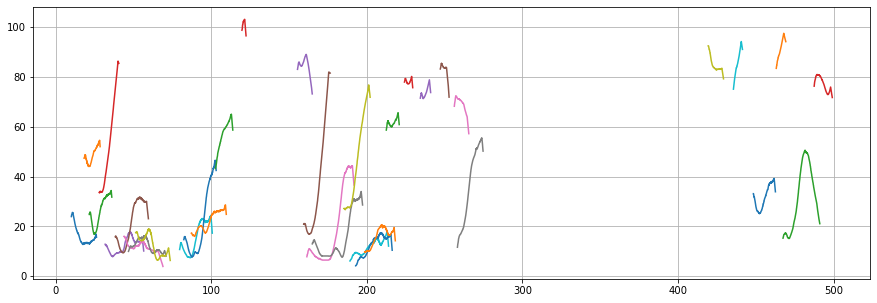

In [427]:
plt.figure(figsize=(15, 5))
for i, row in df_distances.iterrows():
    plt.plot(row["TIME"], row["DISTANCE"])
plt.grid()

In [428]:
len(df_distances)

34